In [23]:
import glob, os
import balltracking.balltrack as blt
from balltracking.balltrack import make_lanes
from pathlib import PurePath
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.ndimage.filters import gaussian_filter

In [2]:
def get_lanes_rgba(lanes_data, color=(0,1,1)):
    # Create an alpha channel from the lanes data.
    lanes_norm = Normalize(0, 0.5 * lanes_data.max(), clip=True)(lanes_data)
    lanes_rgba = np.ones(lanes_norm.shape + (4,))
    lanes_rgba[..., 0] = color[0]
    lanes_rgba[..., 1] = color[1]
    lanes_rgba[..., 2] = color[2]
    lanes_rgba[..., 3] = lanes_norm
    return lanes_rgba


In [3]:
datadir = '/Users/rattie/Data/Ben/DeepVelU_AR_Moat_Flows/'
# Units
dx = 367.93916*1e3 # m / px
dt = 45.0 # sec/frame
### Lanes parameters
nsteps = 50
maxstep = 1

### Simulation data

In [5]:
# Intensity
icf = PurePath(datadir, 'MURaM_AR_at_SDO_resolution', 'avg', 'SDO_ic1_625000-626500.fits').as_posix()
icfits = fits.open(icf)
ic = icfits[0].data[0:-11, 0:-11]
ics = ic[0:50, 0:50]
# Magnetograms
bzf = PurePath(datadir, 'MURaM_AR_at_SDO_resolution', 'avg', 'SDO_bz1_625000-626500.fits').as_posix()
bzfits = fits.open(bzf)
bz = bzfits[0].data[0:-11, 0:-11]
# Velocities. Units in cm/s. Need to convert to px/frame for vx and vy for computing the lanes
vxf = PurePath(datadir, 'MURaM_AR_at_SDO_resolution', 'avg', 'SDO_vx1_625000-626500.fits').as_posix()
vx_sim = fits.open(vxf)[0].data[0:256, 0:256]* 1e-2 /dx *dt
vyf = PurePath(datadir, 'MURaM_AR_at_SDO_resolution', 'avg', 'SDO_vz1_625000-626500.fits').as_posix()
vy_sim = fits.open(vyf)[0].data[0:256, 0:256]* 1e-2 /dx *dt
vzf = PurePath(datadir, 'MURaM_AR_at_SDO_resolution', 'avg', 'SDO_vz1_625000-626500.fits').as_posix()
vz_sim = fits.open(vzf)[0].data[0:256, 0:256] / 100000 # km/s
# Smooth
vx_sim_sm7 = gaussian_filter(vx_sim, sigma=7/2.35, order=0)
vy_sim_sm7 = gaussian_filter(vy_sim, sigma=7/2.35, order=0)
vz_sim_sm7 = gaussian_filter(vz_sim, sigma=7/2.35, order=0)
# Lanes
lanes_sim0 = make_lanes(vx_sim, vy_sim, nsteps, maxstep)
lanes_sim0_sm7 = make_lanes(vx_sim_sm7, vy_sim_sm7, nsteps, maxstep)

### Deepvel (old architecture)

In [6]:
# Deepvel velocities
f0x = PurePath(datadir, 'DeepVel_Input_Ic', 'DeepVel_vx1_mean_000-029.fits').as_posix()
f0y = PurePath(datadir, 'DeepVel_Input_Ic', 'DeepVel_vy1_mean_000-029.fits').as_posix()
vx_dv = fits.open(f0x)[0].data[0:256, 0:256]* 1e-2 /dx *dt
vy_dv = fits.open(f0y)[0].data[0:256, 0:256]* 1e-2 /dx *dt
# smooth
vx_dv_sm7 = gaussian_filter(vx_dv, sigma=7/2.35, order=0)
vy_dv_sm7 = gaussian_filter(vy_dv, sigma=7/2.35, order=0)
# Lanes
lanes_dv = make_lanes(vx_dv, vy_dv, nsteps, maxstep)
lanes_dv_sm7 = make_lanes(vx_dv_sm7, vy_dv_sm7, nsteps, maxstep)

### DeepvelU (U-Net) - input: Ic

In [7]:
f= PurePath(datadir, 'DeepVelU_Input_Ic', 'deepvel_output_simulation_series_00-31.fits').as_posix()
img = fits.open(f)
# Velocity in cm/s. Need to use px/frame
vv_ar_dvu = img[0].data * 1e-2 /dx *dt # px / frame
vx_dvu_all = vv_ar_dvu[:,:,:,1]
vy_dvu_all = vv_ar_dvu[:,:,:,0]
vx_dvu = np.mean(vx_dvu_all, axis=0)
vy_dvu = np.mean(vy_dvu_all, axis=0)
# smooth
vx_dvu_sm7 = gaussian_filter(vx_dvu, sigma=7/2.35, order=0)
vy_dvu_sm7 = gaussian_filter(vy_dvu, sigma=7/2.35, order=0)
# Lanes
lanes_dvu = make_lanes(vx_dvu, vy_dvu, nsteps, maxstep)
lanes_dvu_sm7 = make_lanes(vx_dvu_sm7, vy_dvu_sm7, nsteps, maxstep)

In [8]:
vv_ar_dvu.shape

(30, 256, 256, 2)

### DeepvelU - input: Bz Ic Vz

In [9]:
f= PurePath(datadir, 'DeepVelU_Input_BzIcVz', 'deepvel_output_simulation_series_00-31.fits').as_posix()
img = fits.open(f)
# Velocity in cm/s. Need to use px/frame
vv_ar_dvu = img[0].data * 1e-2 /dx *dt # px / frame
vx_dvu_all = vv_ar_dvu[:,:,:,1]
vy_dvu_all = vv_ar_dvu[:,:,:,0]
vx_dvu3 = np.mean(vx_dvu_all, axis=0)
vy_dvu3 = np.mean(vy_dvu_all, axis=0)
# smooth
vx_dvu3_sm7 = gaussian_filter(vx_dvu3, sigma=7/2.35, order=0)
vy_dvu3_sm7 = gaussian_filter(vy_dvu3, sigma=7/2.35, order=0)
# Lanes
lanes_dvu3 = make_lanes(vx_dvu3, vy_dvu3, nsteps, maxstep)
lanes_dvu3_sm7 = make_lanes(vx_dvu3_sm7, vy_dvu3_sm7, nsteps, maxstep)

In [10]:
xmin, xmax, ymin, ymax = [85, 85+50, 85, 85+50]
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(22, 8))
#axs[0].imshow(lanes, origin='lower', cmap='Blues')
imvz = axs[0].imshow(vz_sim, vmin=-1.2, vmax=1.2, origin='lower', cmap='RdBu_r')
fig.colorbar(imvz, ax = axs[0])
axs[0].quiver(vx_dvu, vy_dvu, scale=6)
axs[0].axis([xmin, xmax, ymin, ymax])

imvz2 = axs[1].imshow(lanes_dvu, vmax=10, origin='lower', cmap='Blues')
fig.colorbar(imvz2, ax = axs[1])
axs[1].quiver(vx_dvu, vy_dvu, scale=6)
axs[1].axis([xmin, xmax, ymin, ymax])

[85, 135, 85, 135]

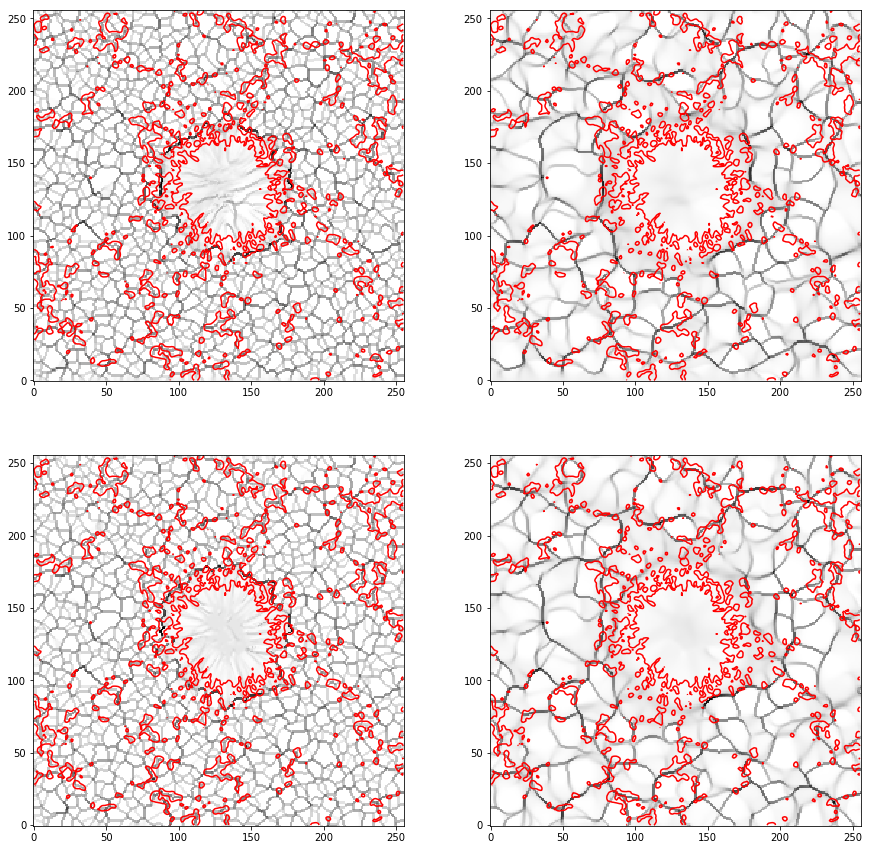

In [11]:
%matplotlib inline
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(15,15))
axs[0, 0].imshow(lanes_dv, origin='lower', cmap='gray_r')
axs[0, 0].contour(np.abs(bz), levels=[50], colors=['red'])
axs[0, 1].imshow(lanes_dv_sm7, origin='lower', cmap='gray_r')
axs[0, 1].contour(np.abs(bz), levels=[50], colors=['red'])

axs[1, 0].imshow(lanes_dvu3, origin='lower', cmap='gray_r')
axs[1, 0].contour(np.abs(bz), levels=[50], colors=['red'])
axs[1, 1].imshow(lanes_dvu3_sm7, origin='lower', cmap='gray_r')
axs[1, 1].contour(np.abs(bz), levels=[50], colors=['red'])

# axs[0].set_colorbar()
plt.savefig('lanes_bz.png', dpi=300)

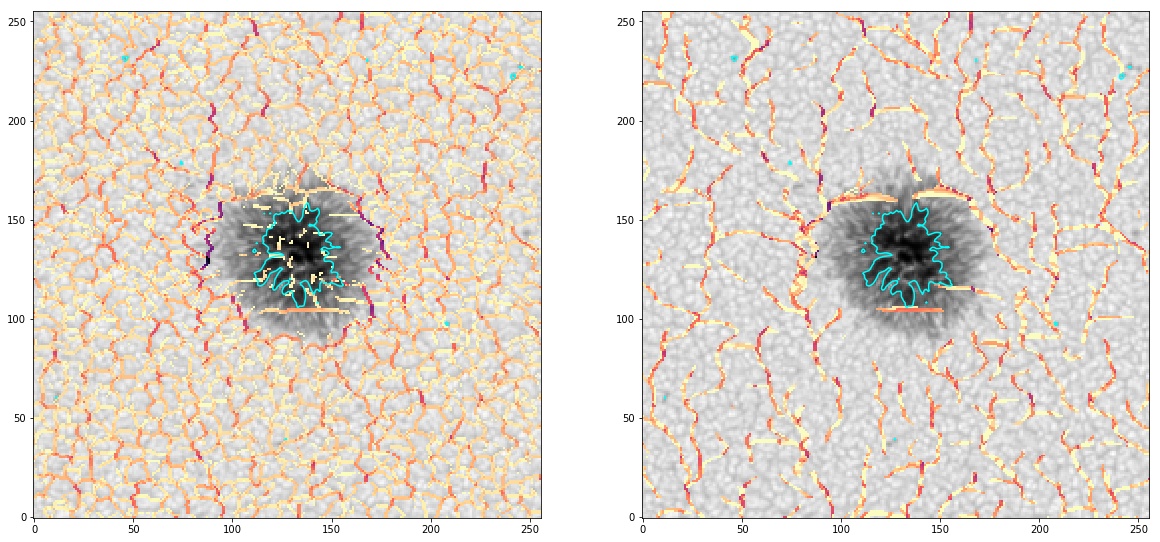

In [16]:
masked = np.ma.masked_where(lanes_sim0 < 2.5, lanes_sim0)
masked_sm7 = np.ma.masked_where(lanes_sim0_sm7 < 2.5, lanes_sim0)

fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(20, 10))
axs[0].imshow(ic, origin='lower', cmap='gray')
axs[0].contour(np.abs(bz), levels=[500], colors=['cyan'])
axs[0].imshow(masked, origin='lower', cmap='magma_r', interpolation='none')
axs[1].imshow(ic, origin='lower', cmap='gray')
axs[1].contour(np.abs(bz), levels=[500], colors=['cyan'])
axs[1].imshow(masked_sm7, origin='lower', cmap='magma_r', interpolation='none')

In [17]:
import fitsio

In [18]:
sdofits = fitsio.read('/Users/rattie/Data/Ben/DeepVelU_AR_Moat_Flows/SDO_inference/output/sdo_output_320frames.fits')

In [19]:
dvu_sdo_vx = np.mean(sdofits[0:160, :, :, 1], axis=0) * 1e-2 /dx *dt
dvu_sdo_vy = np.mean(sdofits[0:160, :, :, 0], axis=0) * 1e-2 /dx *dt

### Lanes parameters
nsteps = 50
maxstep = 1
dvu_sdo_vx_sm15 = gaussian_filter(dvu_sdo_vx, sigma=15/2.35, order=0)
dvu_sdo_vy_sm15 = gaussian_filter(dvu_sdo_vy, sigma=15/2.35, order=0)
dvu_sdo_lanes_sm15 = make_lanes(dvu_sdo_vx_sm15, dvu_sdo_vy_sm15, nsteps, maxstep)

### Balltracking

In [25]:
tracking_dir ='/Users/rattie/Data/SDO/HMI/EARs/AR12673_2017_09_01/python_balltracking'
fwhm = 15
tavg = 160
vx_files = sorted(glob.glob(os.path.join(tracking_dir,'vx_fwhm%d_tavg%d_[0-9]*.fits'%(fwhm, tavg))))
vy_files = sorted(glob.glob(os.path.join(tracking_dir,'vy_fwhm%d_tavg%d_[0-9]*.fits'%(fwhm, tavg))))

In [26]:
bt_sdo_vx = fitsio.read(vx_files[0])
bt_sdo_vy = fitsio.read(vy_files[0])
bt_sdo_lanes = make_lanes(bt_sdo_vx, bt_sdo_vy, nsteps, maxstep)

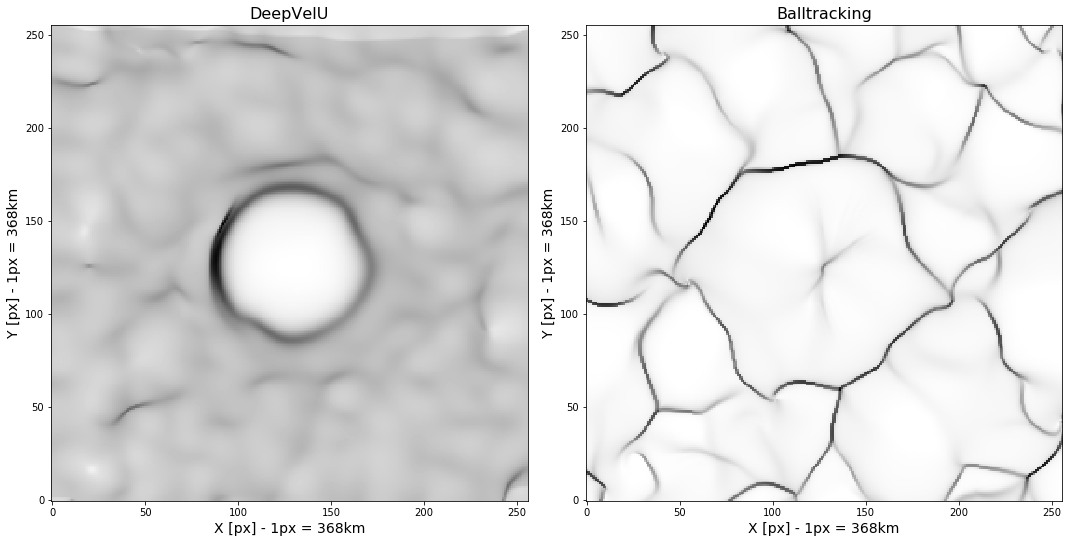

In [34]:
%matplotlib inline
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(15, 10))
axs[0].imshow(dvu_sdo_lanes_sm15, origin='lower', cmap='gray_r')
axs[0].set_title('DeepVelU', fontsize=16)
axs[0].set_xlabel('X [px] - 1px = 368km', fontsize=14)
axs[0].set_ylabel('Y [px] - 1px = 368km', fontsize=14)
axs[1].imshow(bt_sdo_lanes[252-128:252+128, 272-128:272+128], origin='lower', cmap='gray_r')
axs[1].set_xlabel('X [px] - 1px = 368km', fontsize=14)
axs[1].set_ylabel('Y [px] - 1px = 368km', fontsize=14)
axs[1].set_title('Balltracking', fontsize=16)
plt.tight_layout()
plt.savefig('DeepVelU_Balltracking.png', dpi=300)